# ML - Fecalguard

Sumber Dataset: https://www.kaggle.com/datasets/allandclive/chicken-disease-1

## Import Library

In [1]:
import shutil
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import kagglehub
import io
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import random

from collections import defaultdict, Counter
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data Loading

In [2]:
# Download latest version
path = kagglehub.dataset_download("allandclive/chicken-disease-1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chicken-disease-1


In [3]:
df = pd.read_csv('/kaggle/input/chicken-disease-1/train_data.csv')
df.sample(10)

,images,label
5404,cocci.1440.jpg,Coccidiosis
591,cocci.978.jpg,Coccidiosis
2145,healthy.1236.jpg,Healthy
6520,healthy.316.jpg,Healthy
957,healthy.298.jpg,Healthy
1853,healthy.700.jpg,Healthy
8060,healthy.922.jpg,Healthy
6659,healthy.1128.jpg,Healthy
4150,healthy.1773.jpg,Healthy
7714,healthy.598.jpg,Healthy


In [4]:
df['label'].value_counts()

,count
label,
Salmonella,2625
Coccidiosis,2476
Healthy,2404
New Castle Disease,562


In [5]:
# menghitung jumlah data & resolusi data dalam dataset
dataset_path = "/kaggle/input/chicken-disease-1"

# inisialisasi variabel penampung
label_counts = defaultdict(int)
resolution_counter = Counter()
resolution_per_label = defaultdict(set)

# loop menghitung jumlah data & resolusi data dalam dataset
for label in os.listdir(dataset_path):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    label_counts[label] += 1
                    resolution = img.size  # (width, height)
                    resolution_counter[resolution] += 1
                    resolution_per_label[label].add(resolution)
            except Exception as e:
                print(f"Gagal membuka {img_path}: {e}")

In [6]:
print("\nResolusi gambar dalam dataset:")
for label, resolutions in resolution_per_label.items():
    print(f"{label}: {list(resolutions)}\n")


Resolusi gambar dalam dataset:
Train: [(224, 224)]



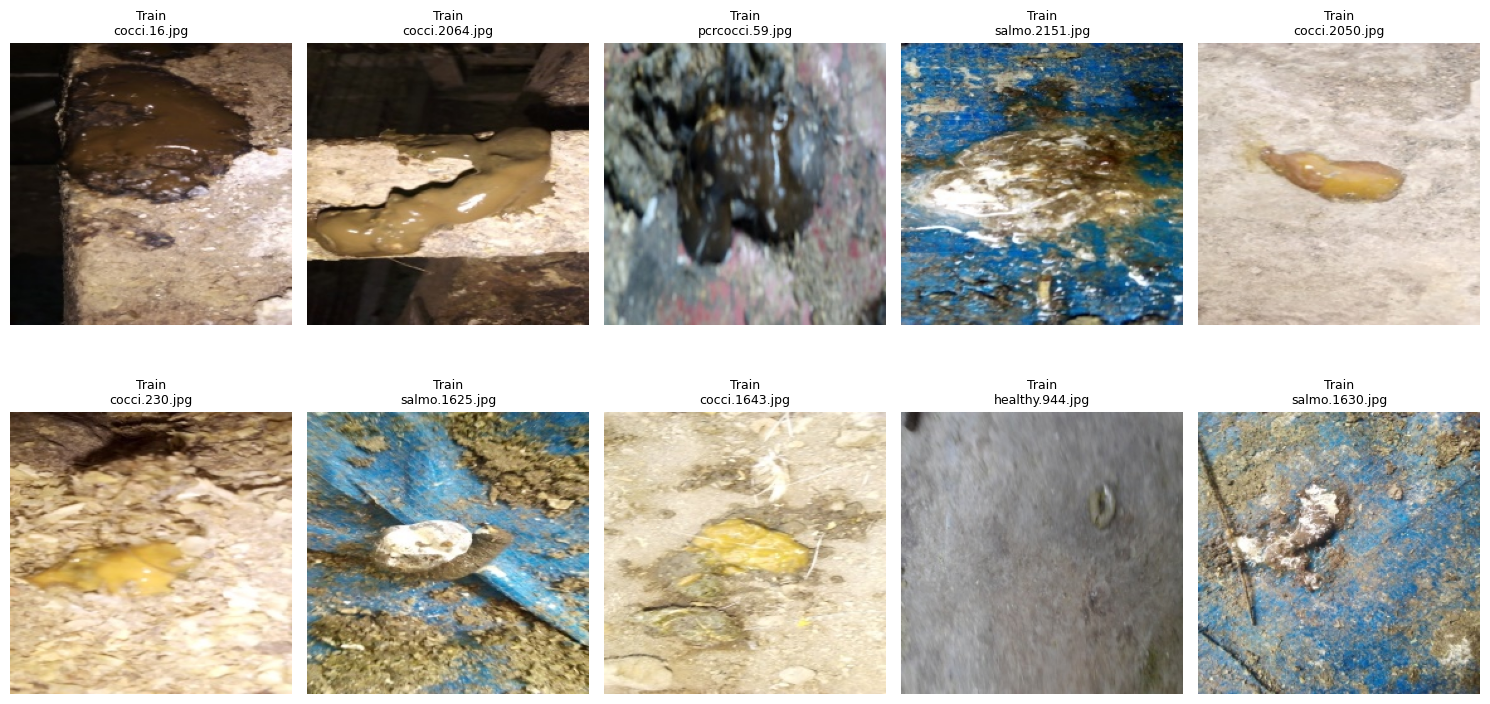

In [7]:
FOLDER = Path("/kaggle/input/chicken-disease-1/Train")

# ambil semua file JPG, lalu acak
all_images = list(FOLDER.rglob("*.jpg"))      # rglob agar menangkap subfolder per-label
random.shuffle(all_images)
selected = all_images[:10]

plt.figure(figsize=(15,8))
for i, img_path in enumerate(selected, 1):
    img = mpimg.imread(img_path)
    plt.subplot(2,5,i)
    plt.imshow(img); plt.axis("off")
    plt.title(f"{img_path.parent.name}\n{img_path.name}", fontsize=9)  # tampilkan label & nama file
plt.tight_layout(); plt.show()

## Data Splitting

split ratio

train:val:test = 80:15:15

In [8]:
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

print(f"Train {train_df['label'].value_counts()} \n")
print(f"Val {val_df['label'].value_counts()} \n")
print(f"Test {test_df['label'].value_counts()} \n")

Train label
Salmonella            1896
Coccidiosis           1788
Healthy               1737
New Castle Disease     406
Name: count, dtype: int64 

Val label
Salmonella            335
Coccidiosis           316
Healthy               306
New Castle Disease     72
Name: count, dtype: int64 

Test label
Salmonella            394
Coccidiosis           372
Healthy               361
New Castle Disease     84
Name: count, dtype: int64 



## Data Augmentation

In [21]:
df = pd.read_csv('/kaggle/input/chicken-disease-1/train_data.csv')
print(df.columns)

Index(['images', 'label'], dtype='object')


In [22]:
train_datagen = ImageDataGenerator(
    # rescale        = 1./255,
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    shear_range    = 0.1,
    zoom_range     = 0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory='/kaggle/input/chicken-disease-1/Train',
    x_col='images',
    y_col='label',
    target_size=(244,244),
    class_mode='categorical',
    batch_size=32
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, directory='/kaggle/input/chicken-disease-1/Train',
    x_col='images',
    y_col='label',
    target_size=(244,244),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, directory='/kaggle/input/chicken-disease-1/Train',
    x_col='images',
    y_col='label',
    target_size=(244,244),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5827 validated image filenames belonging to 4 classes.
Found 1029 validated image filenames belonging to 4 classes.
Found 1211 validated image filenames belonging to 4 classes.


## Modelling

In [23]:
# Membuat base model menggunakan MobileNetV2
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling= 'max')

In [24]:
# Membekukan lapisan-lapisan pada base model agar tidak terlatih pada awalnya
base_model.trainable = False

In [25]:
# Fungsi untuk membangun model CNN dengan MobileNetV2 sebagai base model
def build_cnn_with_resnet50(input_shape=(244, 244, 3), num_classes=4):
    # Memuat model MobileNetV2 tanpa lapisan top (fully connected)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Membekukan lapisan-lapisan pada base model agar tidak terlatih selama pelatihan awal
    base_model.trainable = False

    # Membangun model Sequential
    model = models.Sequential([
        base_model,  # Menambahkan MobileNetV2 sebagai base model
        layers.GlobalAveragePooling2D(),  # Menggunakan pooling untuk mereduksi dimensi
        layers.Dense(256, activation='relu'),  # Lapisan Dense untuk klasifikasi

        layers.BatchNormalization(),  # Normalisasi untuk stabilitas pelatihan
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),

        layers.Dropout(0.2),  # Dropout untuk mengurangi overfitting
        layers.Dense(num_classes, activation='softmax')  # Lapisan output untuk klasifikasi
    ])

    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',  # Fungsi loss untuk klasifikasi multi-kelas
                  metrics=['accuracy'])

    # Menampilkan ringkasan model
    model.summary()

    return model

In [26]:
# Membangun model awal
model = build_cnn_with_resnet50()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,154,692 (92.14 MB)

 Trainable params: 566,468 (2.16 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [27]:
# Fine-tuning setelah pelatihan awal
base_model.trainable = True

In [28]:
# Fine-tuning setelah pelatihan awal
# Membuka kembali lapisan-lapisan base model untuk fine-tuning
base_model = model.layers[0]  # Mendapatkan base model MobileNetV2 dari model

base_model.trainable = True

In [29]:
# Membekukan semua lapisan kecuali 20 lapisan terakhir
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [30]:
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 132s 596ms/step - accuracy: 0.7450 - loss: 0.6823 - val_accuracy: 0.9193 - val_loss: 0.2537
Epoch 2/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 100s 546ms/step - accuracy: 0.9467 - loss: 0.1782 - val_accuracy: 0.9524 - val_loss: 0.1408
Epoch 3/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 95s 520ms/step - accuracy: 0.9652 - loss: 0.1100 - val_accuracy: 0.9485 - val_loss: 0.1824
Epoch 4/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 93s 510ms/step - accuracy: 0.9704 - loss: 0.0919 - val_accuracy: 0.9553 - val_loss: 0.1598
Epoch 5/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 95s 522ms/step - accuracy: 0.9787 - loss: 0.0715 - val_accuracy: 0.9563 - val_loss: 0.1843
Epoch 6/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 94s 512ms/step - accuracy: 0.9847 - loss: 0.0481 - val_accuracy: 0.9602 - val_loss: 0.1987
Epoch 7/25
183/183 ━━━━━━━━━━━━━━━━━━━━ 93s 507ms/step - accuracy: 0.9800 - loss: 0.0574 - val_accuracy: 0.9611 - val_loss: 0.1633


## Evaluation

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.9498 - loss: 0.1539
Test Loss: 0.1600 | Test Accuracy: 0.9538


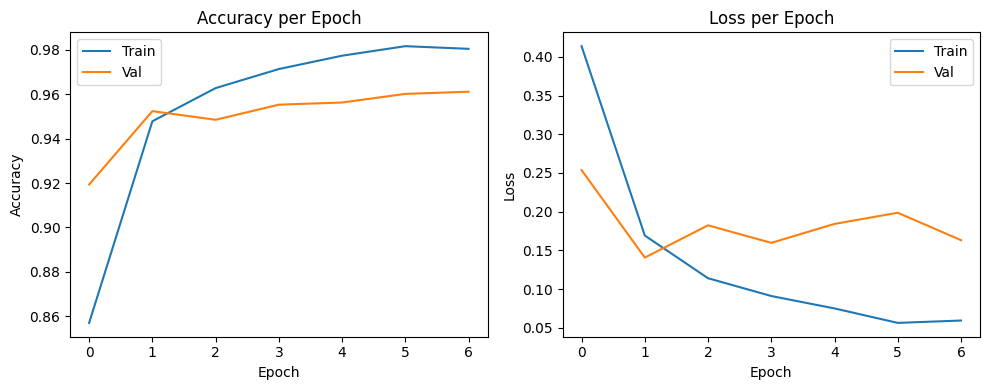

In [31]:
# 1. Evaluasi test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# 2. Plot kurva akurasi & loss
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Train')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Train')
plt.plot(epochs_range, history.history['val_loss'], label='Val')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step


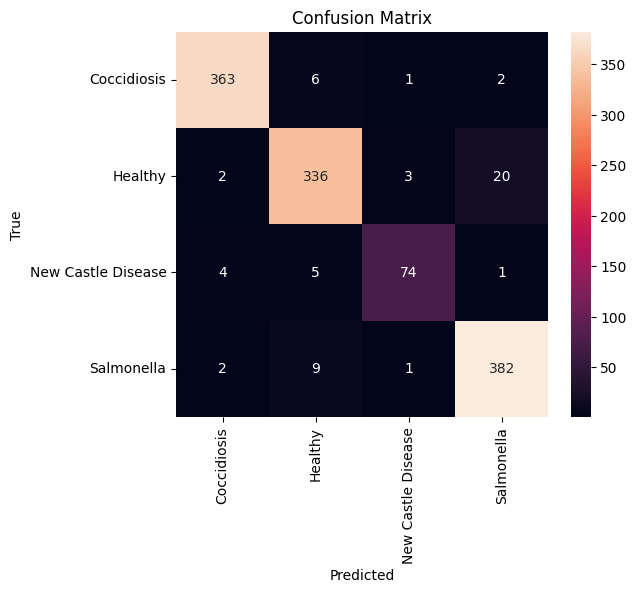

In [32]:
# Prediksi seluruh test set
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes            # label integer ground-truth

cm = confusion_matrix(y_true, y_pred)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

In [33]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

predictions = model.predict(test_gen)

# The predictions will be in a one-hot encoded format, so convert them to labels
predicted_classes = np.argmax(predictions, axis=1)

# Getting the true labels from the generator
true_classes = test_gen.labels

# Getting the class labels from the generator for later use in the classification report
class_labels = list(test_gen.class_indices.keys())

# Calculate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
accuracy = accuracy_score(true_classes, predicted_classes)

print(report)
print('Accuracy:', accuracy)
# Calculate Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step
                    precision    recall  f1-score   support

       Coccidiosis       0.98      0.98      0.98       372
           Healthy       0.94      0.93      0.94       361
New Castle Disease       0.94      0.88      0.91        84
        Salmonella       0.94      0.97      0.96       394

          accuracy                           0.95      1211
         macro avg       0.95      0.94      0.94      1211
      weighted avg       0.95      0.95      0.95      1211

Accuracy: 0.953757225433526
Precision: 0.9505439049259363
Recall: 0.9392624755527699
F1-Score: 0.9446322456396036


## Save Model

In [34]:
model.save("ResNet50_model.h5")

In [35]:
from google.colab import files
files.download("ResNet50_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
labels_ordered = list(train_gen.class_indices.keys())
print(labels_ordered)

['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']


In [37]:
# Urutan berdasarkan indeks (output neuron ke-0 sampai ke-n)
labels_by_index = sorted(train_gen.class_indices.items(), key=lambda x: x[1])
labels_by_index = [label for label, idx in labels_by_index]
print("Urutan label output:", labels_by_index)

Urutan label output: ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']
